In [1]:
import html
import numpy as np
import nltk
import pandas as pd
import pickle
import re
import seaborn as sns

import matplotlib.pyplot as plt
from nltk.util import skipgrams

from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import itertools

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

from scipy.sparse import hstack

In [2]:
df_raw = pd.read_csv('twitter-hate-speech.csv')
df_raw.head()

,unit_id,golden,unit_state,trusted_judgments,last_judgment_at,does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_confidence,created_at,orig_golden,orig_last_judgment_at,orig_trusted_judgments,orig_unit_id,orig_unit_state,updated_at,orig_does_this_tweet_contain_hate_speech,does_this_tweet_contain_hate_speech_gold,does_this_tweet_contain_hate_speech_gold_reason,does_this_tweet_contain_hate_speechconfidence,tweet_id,tweet_text
0,853718217,True,golden,86,NaN,The tweet uses offensive language but not hate...,0.6013,NaN,True,NaN,False,615561535.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,True,1666196150,Warning: penny boards will make you a faggot
1,853718218,True,golden,92,NaN,The tweet contains hate speech,0.7227,NaN,True,NaN,False,615561723.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,True,429512078,Fuck dykes
2,853718219,True,golden,86,NaN,The tweet contains hate speech,0.5229,NaN,True,NaN,False,615562039.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,True,395623778,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,853718220,True,golden,98,NaN,The tweet contains hate speech,0.5184,NaN,True,NaN,False,615562068.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,True,497514685,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,853718221,True,golden,88,NaN,The tweet uses offensive language but not hate...,0.5185,NaN,True,NaN,False,615562488.0,golden,NaN,The tweet contains hate speech,The tweet contains hate speech\nThe tweet uses...,NaN,True,588923553,@Zhugstubble You heard me bitch but any way I'...


In [3]:
df = df_raw.loc[:,['does_this_tweet_contain_hate_speech','tweet_text']]
df['does_this_tweet_contain_hate_speech']= df['does_this_tweet_contain_hate_speech'].map({'The tweet uses offensive language but not hate speech': 'offensive',
                                               'The tweet contains hate speech': 'hate',
                                               'The tweet is not offensive' : 'ok'})
df = df.rename(columns={"does_this_tweet_contain_hate_speech": "contains"})
df.tweet_text = df.tweet_text.apply(lambda s:  html.unescape(s))
df.head(15)

,contains,tweet_text
0,offensive,Warning: penny boards will make you a faggot
1,hate,Fuck dykes
2,hate,@sizzurp__ @ILIKECATS74 @yoPapi_chulo @brandon...
3,hate,"""@jayswaggkillah: ""@JacklynAnnn: @jayswaggkill..."
4,offensive,@Zhugstubble You heard me bitch but any way I'...
5,hate,@elaynay your a dirty terrorist and your relig...
6,hate,RT @ivanrabago_: @_WhitePonyJr_ looking like f...
7,hate,Well I thought you knew actually RT @KingHorse...
8,offensive,"@Stonisnipezz I know. It was a joke, faggot."
9,offensive,I'm tired of people saying I look like my brot...


In [4]:
df.contains.value_counts()

ok           7274
offensive    4836
hate         2399
Name: contains, dtype: int64

In [5]:
tweet_text = df.tweet_text.str.lower()

### remove urls
tweet_text= tweet_text.str.replace('http\S+|www.\S+', '')

### remove emoji's
def filter_emoji(in_str):
    emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                       "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', in_str)

def remove_repeating_chars(in_str):
    return ''.join(''.join(s)[:2] for _, s in itertools.groupby(in_str))

tweet_text= tweet_text.apply(filter_emoji)

## remove mentions
tweet_text= tweet_text.str.replace('@[\w\-]+:?', '')

## remove all non alphabets and punctuations
#tweet_text= tweet_text.str.replace('[^a-zA-z.,!? ]+', '')
tweet_text= tweet_text.str.replace('[\"\']+', '')
#weet_text= tweet_text.str.replace('[^a-zA-z.,!? ]+', '')

tweet_text= tweet_text.apply(remove_repeating_chars)

X_raw = tweet_text

# convert the labels to numbers
y_raw = df.contains.map({'ok': 0, 'offensive': 1, 'hate': 2})
y = y_raw

tweet_text[:11]

0          warning: penny boards will make you a faggot
1                                            fuck dykes
2         at least i dont look like jefree starr faggot
3                           is a fag jackie jealous nee
4      you heard me bitch but any way im back th tex...
5      your a dirty terrorist and your religion is a...
6                             rt  looking like faggots?
7     well i thought you knew actually rt  man why y...
8                        i know. it was a joke, faggot.
9     im tired of people saying i look like my broth...
10    #voteblue2014 yeah. cuz 8 million people in fa...
Name: tweet_text, dtype: object

In [6]:
cv = StratifiedKFold(n_splits=10, shuffle=True)
stemmer = PorterStemmer()

stopwords= stopwords.words("english")
other_exclusions = ["ff", "rt"]
stopwords.extend(other_exclusions)

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""
    #return [token.strip() for token in tweet.split()]
    #tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    #tweet = " ".join(re.split("[^^a-zA-Z.,!?]*", tweet)).strip()
    tweet = " ".join(re.split("[^a-zA-Z#]+", tweet)).strip()
    #tweet = " ".join(re.split("[ ]*", tweet)).strip()
    return tweet.split()

def tokenize(tweet):
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

In [7]:
def get_metric(vectorizer, X_raw, y_raw, name):
    result={'name':name} 
    y = y_raw
    X = vectorizer.fit_transform(X_raw)
    result['shape'] = X.shape

    aucs = []
    for train, test in cv.split(X, y):
        classifier.fit(X[train], y[train])
        y_preds = classifier.predict(X[test])
        accuracy = accuracy_score(y[test], y_preds)
        aucs.append(accuracy)

    result['accuracies']  = aucs
    result['mean_accuracy'] = np.mean(aucs)
    #result['y_preds'] = y_preds
    return result

In [8]:
classifier = LinearSVC(C=1)
vectorizer_unigrams = TfidfVectorizer(
    ngram_range=(1,1),
    stop_words=other_exclusions,
    tokenizer=basic_tokenize)

result = get_metric(vectorizer_unigrams, X_raw, y_raw, "unigrams-basic")
result

{'accuracies': [0.7637741046831956,
  0.7658402203856749,
  0.7768595041322314,
  0.7803030303030303,
  0.7725706409372847,
  0.7849758787043418,
  0.7531034482758621,
  0.7537931034482759,
  0.7689655172413793,
  0.7750172532781229],
 'mean_accuracy': 0.7695202701389399,
 'name': 'unigrams-basic',
 'shape': (14509, 16898)}

In [9]:
vectorizer_bigrams = TfidfVectorizer(
    ngram_range=(2,2),
    stop_words=other_exclusions,
    tokenizer=basic_tokenize)

result = get_metric(vectorizer_bigrams, X_raw, y_raw, "bigrams-basic")
result

{'accuracies': [0.727961432506887,
  0.731404958677686,
  0.7431129476584022,
  0.7272727272727273,
  0.7443142660234321,
  0.7360441075120606,
  0.7303448275862069,
  0.723448275862069,
  0.7358620689655172,
  0.7550034506556246],
 'mean_accuracy': 0.7354769062720612,
 'name': 'bigrams-basic',
 'shape': (14509, 84449)}

In [10]:
vectorizer_trigrams = TfidfVectorizer(
    ngram_range=(3,3),
    stop_words=other_exclusions,
    tokenizer=basic_tokenize)

result = get_metric(vectorizer_trigrams, X_raw, y_raw, "trigrams-basic")
result

{'accuracies': [0.6577134986225895,
  0.6749311294765841,
  0.6680440771349863,
  0.6666666666666666,
  0.6691936595451413,
  0.6726395589248794,
  0.6744827586206896,
  0.66,
  0.6772413793103448,
  0.6846100759144237],
 'mean_accuracy': 0.6705522804216304,
 'name': 'trigrams-basic',
 'shape': (14509, 124960)}

In [11]:
def skipgram_tokenize(tweet, n=None, k=None, include_all=True):
    tokens = [w for w in basic_tokenize(tweet)]
    if include_all:
        result = []
        for i in range(k+1):
            skg = [w for w in skipgrams(tokens, n, i)]
            result = result+skg
    else:
        result = [w for w in skipgrams(tokens, n, k)]
    return result

def make_skip_tokenize(n, k, include_all=True):
    return lambda tweet: skipgram_tokenize(tweet, n=n, k=k, include_all=include_all)

test_str=["test this one two", "test this two three", "test this three four"]
vectorizer_skipgrams = CountVectorizer(stop_words=other_exclusions,
                                       tokenizer=make_skip_tokenize(2,1))
X_skipgram = vectorizer_skipgrams.fit_transform(test_str)
X_skipgram.toarray()

array([[2, 1, 2, 0, 0, 0, 2, 0, 1, 0, 0],
       [0, 0, 2, 0, 1, 0, 0, 1, 2, 0, 2],
       [0, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0]], dtype=int64)

In [12]:
vectorizer_1skipbigram = TfidfVectorizer(stop_words=other_exclusions,
                                       tokenizer=make_skip_tokenize(n=2, k=1))
    

result = get_metric(vectorizer_1skipbigram, X_raw, y_raw, "1-skip-bigrams-basic")
result

{'accuracies': [0.7417355371900827,
  0.7396694214876033,
  0.740358126721763,
  0.7417355371900827,
  0.7332873880082702,
  0.735354927636113,
  0.7296551724137931,
  0.7337931034482759,
  0.7468965517241379,
  0.7370600414078675],
 'mean_accuracy': 0.737954580722799,
 'name': '1-skip-bigrams-basic',
 'shape': (14509, 165792)}

In [13]:
vectorizer_2skipbigram = TfidfVectorizer(stop_words=other_exclusions,
                                       tokenizer=make_skip_tokenize(n=2, k=2))
    
result = get_metric(vectorizer_2skipbigram, X_raw, y_raw, "2-skip-bigrams-basic")
result

{'accuracies': [0.7527548209366391,
  0.7300275482093664,
  0.762396694214876,
  0.7389807162534435,
  0.7422467263955892,
  0.7401791867677464,
  0.7393103448275862,
  0.733103448275862,
  0.7179310344827586,
  0.7439613526570048],
 'mean_accuracy': 0.7400891873020872,
 'name': '2-skip-bigrams-basic',
 'shape': (14509, 235992)}

In [14]:
vectorizer_3skipbigram = TfidfVectorizer(stop_words=other_exclusions,
                                       tokenizer=make_skip_tokenize(n=2, k=3))
result = get_metric(vectorizer_3skipbigram, X_raw, y_raw, "3-skip-bigrams-basic")
result

{'accuracies': [0.7465564738292011,
  0.7424242424242424,
  0.7252066115702479,
  0.731404958677686,
  0.7388008270158511,
  0.7394900068917988,
  0.7475862068965518,
  0.7310344827586207,
  0.7282758620689656,
  0.7501725327812284],
 'mean_accuracy': 0.7380952204914394,
 'name': '3-skip-bigrams-basic',
 'shape': (14509, 296272)}

In [15]:
vectorizer_character_bigram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(2,2))
result = get_metric(vectorizer_character_bigram, X_raw, y_raw, "character bigrams")
result

{'accuracies': [0.7341597796143251,
  0.7417355371900827,
  0.7472451790633609,
  0.7265840220385675,
  0.7339765678842178,
  0.740868366643694,
  0.7158620689655173,
  0.7310344827586207,
  0.7427586206896551,
  0.7370600414078675],
 'mean_accuracy': 0.735128466625591,
 'name': 'character bigrams',
 'shape': (14509, 2482)}

In [16]:
vectorizer_character_trigram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(3,3))
result = get_metric(vectorizer_character_trigram, X_raw, y_raw, "character trigrams")
result

{'accuracies': [0.7775482093663911,
  0.7582644628099173,
  0.759641873278237,
  0.7734159779614325,
  0.7808407994486561,
  0.7677463818056512,
  0.7737931034482759,
  0.7696551724137931,
  0.7620689655172413,
  0.7612146307798482],
 'mean_accuracy': 0.7684189576829443,
 'name': 'character trigrams',
 'shape': (14509, 17309)}

In [17]:
vectorizer_character_4gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(4,4))
result = get_metric(vectorizer_character_4gram, X_raw, y_raw, "character 4-grams")
result

{'accuracies': [0.7644628099173554,
  0.7665289256198347,
  0.7803030303030303,
  0.7658402203856749,
  0.7629221226740179,
  0.7767057201929704,
  0.7593103448275862,
  0.7503448275862069,
  0.766896551724138,
  0.7757073844030365],
 'mean_accuracy': 0.7669021937633851,
 'name': 'character 4-grams',
 'shape': (14509, 61554)}

In [18]:
vectorizer_character_5gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(5,5))
result = get_metric(vectorizer_character_5gram, X_raw, y_raw, "character 5-grams")
result

{'accuracies': [0.756198347107438,
  0.7589531680440771,
  0.7644628099173554,
  0.7713498622589532,
  0.7670572019297036,
  0.7615437629221227,
  0.7641379310344828,
  0.7806896551724138,
  0.7689655172413793,
  0.7646652864044169],
 'mean_accuracy': 0.7658023542032343,
 'name': 'character 5-grams',
 'shape': (14509, 144503)}

In [19]:
vectorizer_character_6gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(6,6))
result = get_metric(vectorizer_character_6gram, X_raw, y_raw, "character 6-grams")
result

{'accuracies': [0.7637741046831956,
  0.7610192837465565,
  0.7589531680440771,
  0.7644628099173554,
  0.7767057201929704,
  0.7725706409372847,
  0.7531034482758621,
  0.76,
  0.7462068965517241,
  0.7529330572808833],
 'mean_accuracy': 0.760972912962991,
 'name': 'character 6-grams',
 'shape': (14509, 253284)}

In [20]:
vectorizer_character_7gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(7,7))

result = get_metric(vectorizer_character_7gram, X_raw, y_raw, "character 7-grams")
result

{'accuracies': [0.7382920110192838,
  0.7472451790633609,
  0.7541322314049587,
  0.7610192837465565,
  0.7580978635423845,
  0.735354927636113,
  0.7448275862068966,
  0.7510344827586207,
  0.7593103448275862,
  0.7619047619047619],
 'mean_accuracy': 0.7511218672110522,
 'name': 'character 7-grams',
 'shape': (14509, 362734)}

In [21]:
vectorizer_character_8gram = TfidfVectorizer(stop_words=other_exclusions,
                                       analyzer='char',
                                       ngram_range=(8,8))
result = get_metric(vectorizer_character_8gram, X_raw, y_raw, "character 8-grams")
result

{'accuracies': [0.7472451790633609,
  0.759641873278237,
  0.7424242424242424,
  0.7417355371900827,
  0.7587870434183321,
  0.7319090282563749,
  0.7351724137931035,
  0.7448275862068966,
  0.7317241379310345,
  0.7349896480331263],
 'mean_accuracy': 0.7428456689594791,
 'name': 'character 8-grams',
 'shape': (14509, 462481)}

In [22]:
def get_metric_oracle(X_raw, y_raw, vectorizers):
    results = {"oracle":{}}
    for train, test in cv.split(X_raw, y_raw):
        y_train = y_raw[train]
        X_train = X_raw[train]
        
        y_test = y_raw[test]
        X_test = X_raw[test]
        
        y_pred_oracle = []
        for name in vectorizers:
            vectorizer = vectorizers[name]
            if name in results:
                result = results[name]
            else:
                result = {}
                results[name] = result
                
            X_train_tr = vectorizer.fit_transform(X_train)
            
            if not "shape" in result:
                result["shape"] = []
            result['shape'].append(X_train_tr.shape)
            classifier.fit(X_train_tr, y_train)
            X_test_tr = vectorizer.transform(X_test)
            y_preds = classifier.predict(X_test_tr)
            accuracy = accuracy_score(y_test, y_preds)
            
            if not "accuracies" in result:
                result["accuracies"] = []           
            
            result['accuracies'].append(accuracy)
            
            if not "y_preds" in result:
                result["y_preds"] = []
                
            result['y_preds'].append(y_preds)   
            
            y_pred_oracle.append(y_preds)
            
        y_pred_oracle = np.matrix(y_pred_oracle).T
        oracle_correct_pred = 0
        oracle_incorrect_index = []
        for i, yt in enumerate(y_test):
            if True in  (y_pred_oracle[i,:] == yt):
                 oracle_correct_pred += 1
            else:
                oracle_incorrect_index.append(test[i])
                
        accuracy = oracle_correct_pred/len(y_test)
        print("Oracle classifier accuracy={}".format(accuracy))
        result = results["oracle"]
    
        if not "accuracies" in result:
            result["accuracies"] = []           
            
        result['accuracies'].append(accuracy)
        
        if not "oracle_incorrect_index" in result:
            result["oracle_incorrect_index"] = []  
            
        result['oracle_incorrect_index'] = oracle_incorrect_index
    return results

In [23]:
vectorizers = {"vectorizer_character_8gram":vectorizer_character_8gram,
              "vectorizer_character_7gram":vectorizer_character_7gram,
              "vectorizer_character_6gram":vectorizer_character_6gram,
              "vectorizer_character_5gram":vectorizer_character_5gram,
              "vectorizer_character_4gram":vectorizer_character_4gram,
              "vectorizer_1skipbigram": vectorizer_1skipbigram,
              "vectorizer_2skipbigram": vectorizer_2skipbigram,
              "vectorizer_3skipbigram": vectorizer_3skipbigram,
              "vectorizer_unigrams": vectorizer_unigrams,
              "vectorizer_bigrams": vectorizer_bigrams,
              "vectorizer_trigrams": vectorizer_trigrams}
               
results = get_metric_oracle(X_raw, y_raw, vectorizers)

Oracle classifier accuracy=0.8808539944903582
Oracle classifier accuracy=0.8980716253443526
Oracle classifier accuracy=0.8849862258953168
Oracle classifier accuracy=0.8746556473829201
Oracle classifier accuracy=0.8842177808407995
Oracle classifier accuracy=0.8911095796002757
Oracle classifier accuracy=0.886896551724138
Oracle classifier accuracy=0.8917241379310344
Oracle classifier accuracy=0.8744827586206897
Oracle classifier accuracy=0.8930296756383713


In [25]:
incorrect_indexes = sorted(set(results["oracle"]["oracle_incorrect_index"]))
print(len(incorrect_indexes))

155


In [27]:
X_incorrect = X_raw[incorrect_indexes]
y_incorrect = y_raw[incorrect_indexes]
incorrect_classified = pd.DataFrame()
incorrect_classified["tweet"] = X_incorrect
incorrect_classified["label"] = y_incorrect
incorrect_classified

,tweet,label
11,"word is you use roids, stupid hypocrite lying...",2
15,they used to tie both ends of a niggers legs t...,2
52,"rt young, attractive, successful, supportive,...",1
80,should check it - he was secretly converted ...,1
250,youre mad cause youre a whole goofy and you go...,1
610,i wonder who prince will look like more. i jus...,1
736,dungeon crawling in ff15 is so fun but creepy ...,1
840,why cant dykes stop having periods,2
853,dykes-lesbians:want to meet girls who like gir...,0
925,ikr what a fucking faggot,2


In [28]:
incorrect_classified.label.value_counts()

2    80
1    66
0     9
Name: label, dtype: int64

In [35]:
summary = []
for name in results:
    result = results[name]
    accuracies = result["accuracies"]
    summary.append({"name": name, "accuracy":np.mean(accuracies)})
df_summary = pd.DataFrame(summary)
df_summary = df_summary.sort_values(by=['accuracy'],ascending=False)
df_summary = df_summary.reset_index()
df_summary

,index,accuracy,name
0,10,0.886003,oracle
1,9,0.771452,vectorizer_character_5gram
2,3,0.769796,vectorizer_character_4gram
3,0,0.768072,vectorizer_unigrams
4,6,0.766350,vectorizer_character_6gram
5,7,0.763041,vectorizer_character_7gram
6,11,0.759182,vectorizer_character_8gram
7,4,0.754289,vectorizer_3skipbigram
8,1,0.753325,vectorizer_2skipbigram
9,5,0.749879,vectorizer_1skipbigram


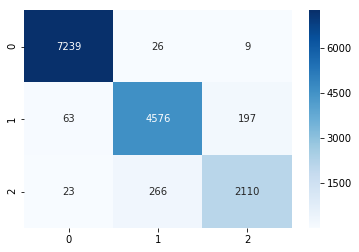

In [41]:
from sklearn.metrics import confusion_matrix

X_tr = vectorizer_character_4gram.fit_transform(X_raw)
classifier.fit(X_tr, y_raw)
y_preds = classifier.predict(X_tr)
cnf_matrix = confusion_matrix(y_raw, y_preds)
sns.heatmap(cnf_matrix,annot=True,cmap=plt.cm.Blues,fmt="d")
plt.show()

In [43]:
train, test = next(cv.split(X_raw, y_raw))

y_train = y_raw[train]
X_train = X_raw[train]

y_test = y_raw[test]
X_test = X_raw[test]

X_train_tr = vectorizer_character_4gram.fit_transform(X_train)
X_test_tr = vectorizer_character_4gram.transform(X_raw)
    
classifier.fit(X_train_tr, y_train)
y_preds = classifier.predict(X_test_tr)
cnf_matrix = confusion_matrix(y_raw, y_preds)
accuracy = accuracy_score(y_raw, y_preds)
accuracy

0.9413467502929216

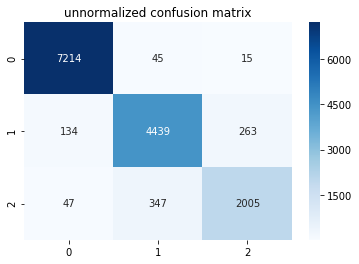

In [44]:
sns.heatmap(cnf_matrix,annot=True,cmap=plt.cm.Blues,fmt="d")
plt.title('unnormalized confusion matrix')
plt.show()

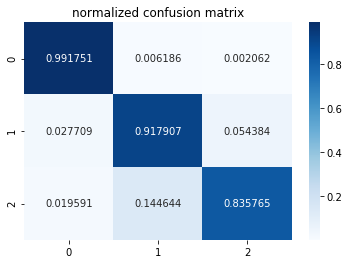

In [45]:
normalized_cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cnf_matrix,annot=True,cmap=plt.cm.Blues,fmt="f")
plt.title('normalized confusion matrix')
plt.show()

In [46]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.linear_model import LogisticRegression
from scipy import sparse
class NB_SVM(BaseEstimator, ClassifierMixin):
    def __init__(self, C=1.0, dual=False, n_jobs=1):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs

    def predict(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(x.multiply(self._r))

    def predict_proba(self, x):
        # Verify that model has been fit
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(x.multiply(self._r))

    def fit(self, x, y):
        # Check that X and y have correct shape
        y = y.values
        x, y = check_X_y(x, y, accept_sparse=True)

        def pr(x, y_i, y):
            p = x[y==y_i].sum(0)
            return (p+1) / ((y==y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(x,1,y) / pr(x,0,y)))
        x_nb = x.multiply(self._r)
        self._clf = LogisticRegression(C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

In [48]:
aucs = []
for train, test in cv.split(X_raw, y_raw):
    y_train = y_raw[train]
    X_train = X_raw[train]

    y_test = y_raw[test]
    X_test = X_raw[test]

    X_train_tr = vectorizer_character_4gram.fit_transform(X_train)
    X_test_tr = vectorizer_character_4gram.transform(X_test)
    
    model = NB_SVM(C=1, dual=True, n_jobs=-1).fit(X_train_tr, y_train)
    y_preds = model.predict(X_test_tr)
    accuracy = accuracy_score(y_test, y_preds)
    aucs.append(accuracy)
    print(accuracy)
result['accuracies']  = aucs
result['mean_accuracy'] = np.mean(aucs)
print("mean accuracy", result['mean_accuracy'])

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.7913223140495868
0.7617079889807162
0.7803030303030303
0.7871900826446281
0.7787732598208132
0.7746381805651275
0.783448275862069
0.7806896551724138
0.7744827586206896
0.7694962042788129
mean accuracy 0.7782051750297888
